In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.signal import butter, filtfilt, hilbert
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False
    print("scipy 없음")

In [3]:
Fs = 10_000     # sampling frequency (Hz)
T = 2.0         # signal duration (s)
t = np.arange(int(Fs * T)) / Fs

rpm = 1800      # shaft speed (RPM)
fm = rpm / 60   # 회전 주파수(변조 주파수) (Hz)
Z = 24          # 치수(geer teeth)
fc = Z * fm     # GMF (Hz)

m_depth = 0.5   # 변조 깊이
A_car = 1.0     # 캐리어(=GMF) 기본 진폭

harmonics = [1, 2, 3]       # GMF의 고조파(1*fc, 2*fc, 3*fc)
harm_amp = [1.0, 0.35, 0.18]        # 각 고조파 진폭
noise_std = 0.05            # 백색잡음 표준편차

# 측대역 생성

In [4]:
am = (1.0 + m_depth * np.cos(2 * np.pi * fm * t))

x = np.zeros_like(t)

for k, ak in zip(harmonics, harm_amp):
    x += ak * am * np.sin(2 * np.pi * (k * fc) * t)

x += noise_std * np.random.randn(len(t))

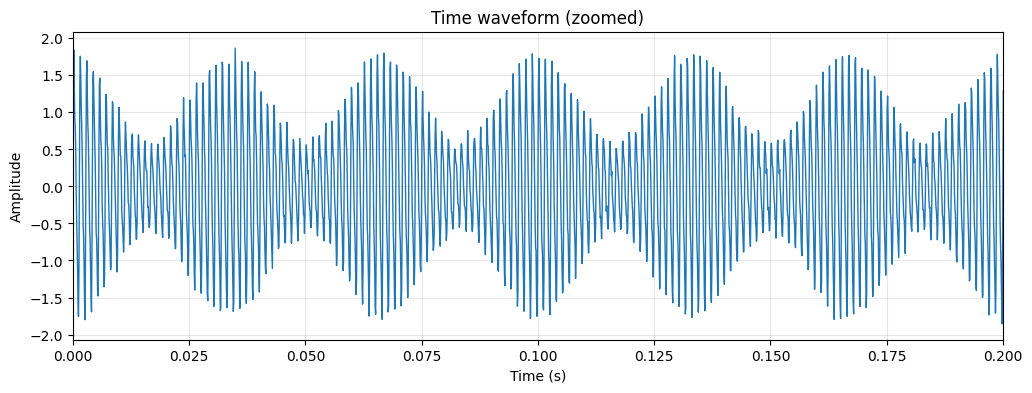

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(t, x, linewidth=1)
plt.xlim(0, 0.2)
plt.title("Time waveform (zoomed)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
def rfft_spectrum(x, Fs, window="hann"):
    N = len(x)

    if window == "hann":
        w = np.hanning(N)
    else:
        w = np.ones(N)

    xw = x * w
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(N, d = 1 / Fs)

    mag = np.abs(X) / (np.sum(w) / 2)

    return f, mag

In [8]:
f, mag = rfft_spectrum(x, Fs, window="hann")
mag_db = 20 * np.log10(mag + 1e-12)

N_side = 6

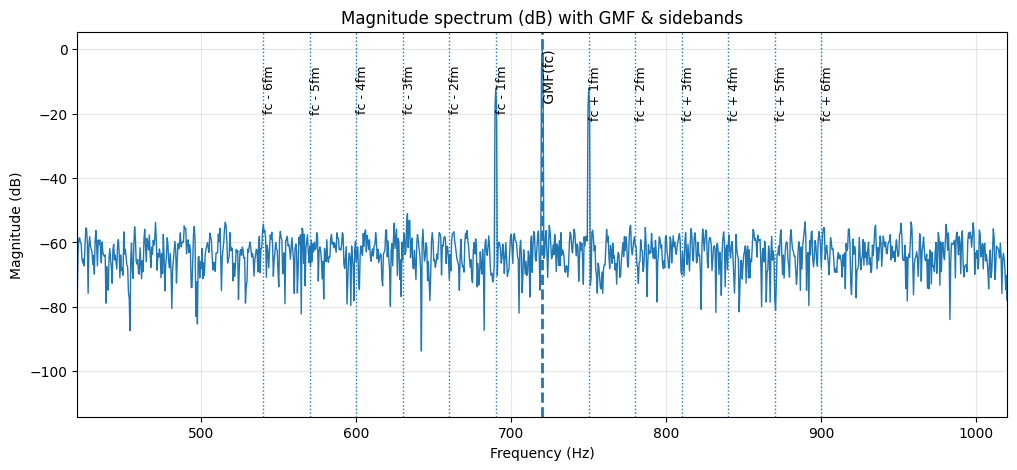

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(f, mag_db, linewidth=1)
plt.title("Magnitude spectrum (dB) with GMF & sidebands")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True, alpha=0.3)

# 관심 대역
span = 10 * fm      # 좌/우로 10 * fm 정도
plt.xlim(max(0, fc - span), fc + span)

plt.axvline(fc, linestyle="--", linewidth=2)
plt.text(fc, np.max(mag_db), " GMF(fc)", rotation=90, va="top")

for n in range(1, N_side + 1):
    f1 = fc - n * fm
    f2 = fc + n * fm

    if f1 > 0:
        plt.axvline(f1, linestyle=":", linewidth=1)
        plt.text(f1, np.max(mag_db) - 5, f" fc - {n}fm", rotation=90, va="top", fontsize=9)
    plt.axvline(f2, linestyle=":", linewidth=1)
    plt.text(f2, np.max(mag_db) - 5, f" fc + {n}fm", rotation=90, va="top", fontsize=9)

plt.show()

# nX 회전 성분 포함 및 GMF + 측대역 동시 포함

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
Fs = 10_000         # Hz
T = 3.0             # s
t = np.arange(int(Fs * T)) / Fs

rpm = 1800
f1x = rpm / 60.0    # 1X = 30Hz

Z = 24
fc = Z * f1x        # GMF = 720Hz

noise_std = 0.02

## nX 성분 만들기: 1X, 2X, 3X, ...

In [14]:
rng = np.random.default_rng(0)

nX_list = [1, 2, 3, 4, 5]       # 관심 있는 nX 차수
nX_amp = [0.60, 0.25, 0.12, 0.08, 0.05]         # 각 차수 진폭 (원하는대로 조절)
nX_phi = rng.uniform(0, 2 * np.pi, len(nX_list))

x_nx = np.zeros_like(t)

for n, a, ph in zip(nX_list, nX_amp, nX_phi):
    x_nx += a * np.sin(2 * np.pi * (n * f1x) * t + ph)

## GMF + 측대역 만들기 (진폭변조 AM)

AM이면 원칙적으로 $f_{c}  \pm 1X$ 중심으로 잘 보임

In [15]:
m_depth = 0.6       # 변조 깊이
am = (1.0 + m_depth * np.cos(2 * np.pi * f1x * t))      # 변조 주파수 = 1X

gmf_harm = [1, 2, 3]        # fc, 2fc, 3fc
gmf_amp = [1.0, 0.35, 0.15]

x_gmf = np.zeros_like(t)

for k, ak in zip(gmf_harm, gmf_amp):
    x_gmf += ak * am * np.sin(2 * np.pi * (k * fc) * t + rng.uniform(0, 2 * np.pi))

x = x_nx + x_gmf + noise_std * rng.standard_normal(len(t))

In [16]:
def rfft_spectrum_db(x, Fs, window="hann"):
    N = len(x)

    if window == "hann":
        w = np.hanning(N)
    else:
        w = np.ones(N)

    X = np.fft.rfft(x * w)
    f = np.fft.rfftfreq(N, d=1/Fs)

    mag = np.abs(X) / (np.sum(w) / 2)
    db = 20 * np.log10(mag + 1e-12)

    return f, mag, db

In [17]:
f, mag, db = rfft_spectrum_db(x, Fs, window="hann")

In [18]:
def plot_lowband_nX(f, db, f1x, n_max=10, fmax=None, title="Low-frequency spectrum with nX components"):
    plt.figure(figsize=(12, 5))
    plt.plot(f, db, linewidth=1)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)

    if fmax is None:
        fmax = (n_max + 1) * f1x
    plt.xlim(0, fmax)

    y_top = np.max(db[(f >= 0) & (f <= fmax)])

    for n in range(1, n_max + 1):
        fn = n * f1x
        plt.axvline(fn, linestyle="--", linewidth=1)
        plt.text(fn, y_top, f" {n}X", rotation=90, va="top", fontsize=9)

    plt.show()

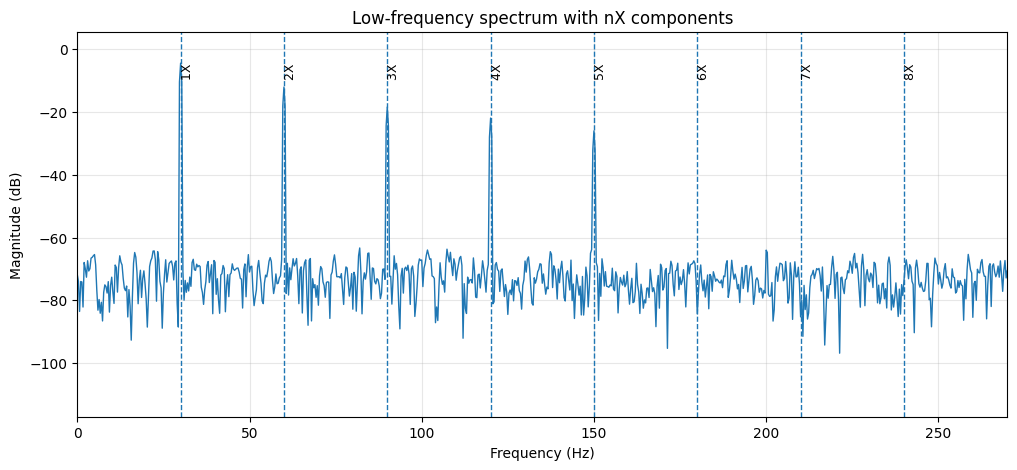

In [19]:
plot_lowband_nX(f, db, f1x, n_max=8)

In [20]:
def plot_gmf_sidebands(f, db, fc, fm, n_side=6, span_mult=10, title="GMF band with sidebands"):
    plt.figure(figsize=(12, 5))
    plt.plot(f, db, linewidth=1)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)

    span = span_mult * fm
    fmin = max(0, fc - span)
    fmax = fc + span
    plt.xlim(fmin, fmax)

    plt.axvline(fc, linestyle="--", linewidth=2)
    y_top = np.max(db[(f >= fmin) & (f <= fmax)])
    plt.text(fc, y_top, " GMF(fc)", rotation=90, va="top")

    for n in range(1, n_side + 1):
        plt.axvline(fc - n * fm, linestyle=":", linewidth=1)
        plt.axvline(fc + n * fm, linestyle=":", linewidth=1)

    plt.show()

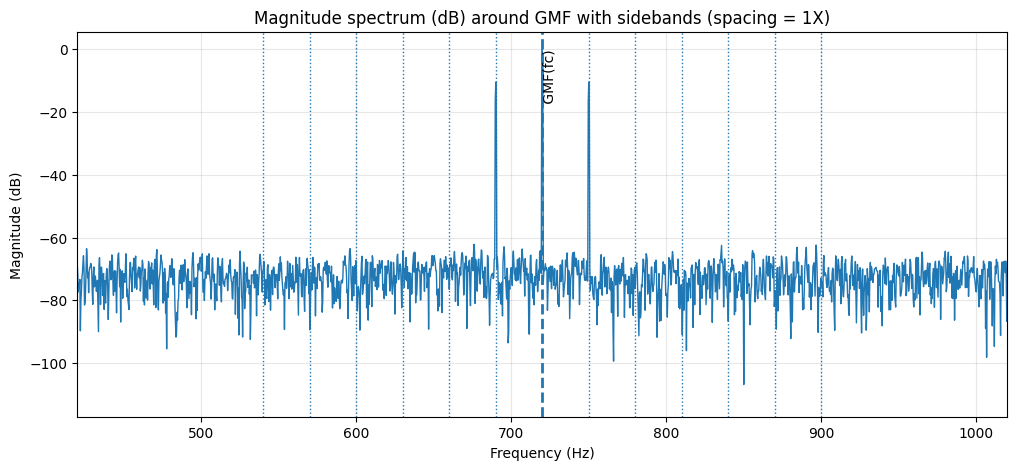

In [21]:
plot_gmf_sidebands(f, db, fc, f1x, n_side=6, span_mult=10, title="Magnitude spectrum (dB) around GMF with sidebands (spacing = 1X)")

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_two_bands(f, db, f1x, fc, nX_max=10, n_side=6, span_mult=10, use_logx=False):
    _, axes = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

    ax = axes[0]
    fmax_low = (nX_max + 1) * f1x
    ax.plot(f, db, linewidth=1)
    ax.set_title("Low-frequency band (nX)")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Magnitude [dB]")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, fmax_low)

    y_top = np.max(db[(f>=0) & (f<=fmax_low)])
    for n in range(1, nX_max+1):
        fn = n * f1x
        ax.axvline(fn, linestyle="--", linewidth=1)
        ax.text(fn, y_top, f"  {n}X", rotation=90, va="top", fontsize=9)

    ax = axes[1]
    span = span_mult * f1x
    fmin_g = max(0, fc - span)
    fmax_g = fc + span
    ax.plot(f, db, linewidth=1)
    ax.set_title("GMF band (GMF & sidebands)")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Magnitude [dB]")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(fmin_g, fmax_g)

    y_top2 = np.max(db[(f>=fmin_g) & (f<=fmax_g)])
    ax.axvline(fc, linestyle="--", linewidth=2)
    ax.text(fc, y_top2, "  GMF", rotation=90, va="top")

    for k in range(1, n_side+1):
        ax.axvline(fc - k*f1x, linestyle=":", linewidth=1)
        ax.axvline(fc + k*f1x, linestyle=":", linewidth=1)

    if use_logx:
        plt.figure(figsize=(12,4))
        plt.plot(f[1:], db[1:], linewidth=1)
        plt.xscale("log")
        plt.title("Full spectrum (log-x) — low + GMF visible together")
        plt.xlabel("Frequency [Hz] (log scale)")
        plt.ylabel("Magnitude [dB]")
        plt.grid(True, which="both", alpha=0.3)
        plt.show()

    plt.show()

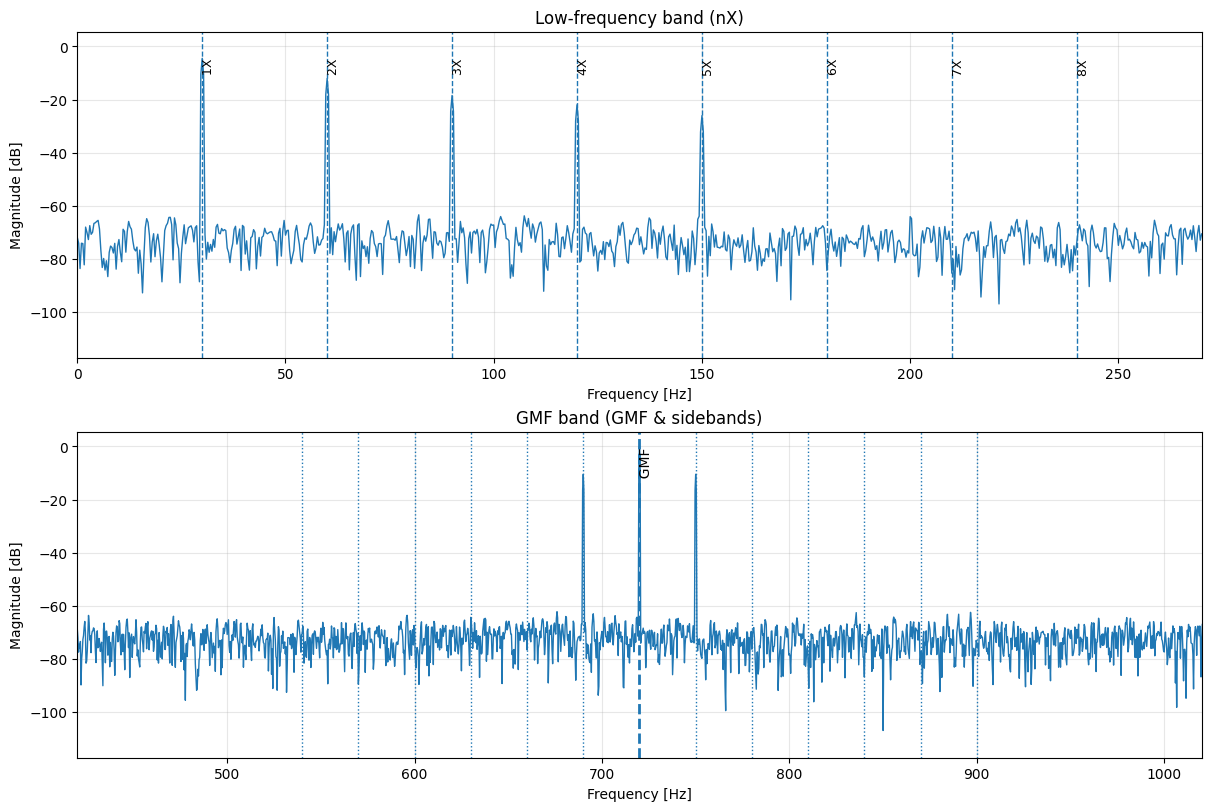

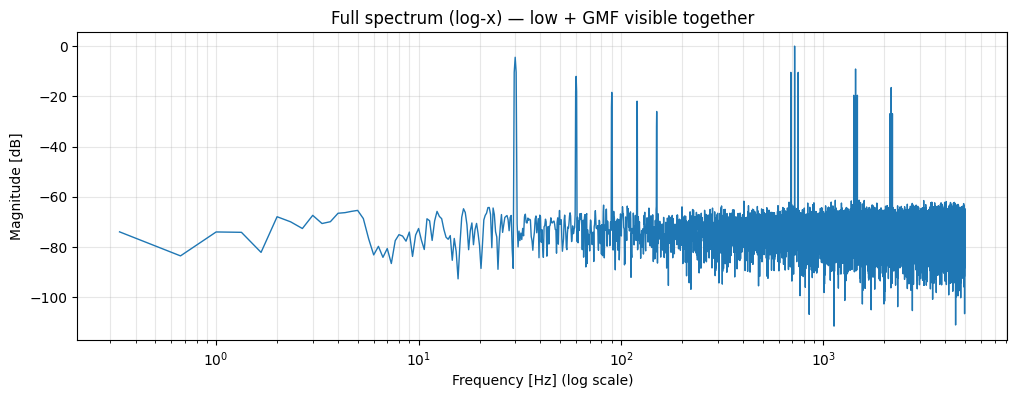

In [23]:
plot_two_bands(f, db, f1x=f1x, fc=fc, nX_max=8, n_side=6, span_mult=10, use_logx=True)

> 위에서 확인할 수 있는 것처럼, 확대해서 보는 경우 분리되어 보이나, 실제로는 같은 FFT에서 저주파 nX도, GMF 및 측대역도 함께 존재함 (맨 아래 Plot).